In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
!pip install '/kaggle/input/mtcnn-package/mtcnn-0.1.0-py3-none-any.whl'

In [1]:
import cv2
import os
import json
import numpy as np
import pandas as pd
#from PIL import Image, ImageChops, ImageEnhance, ImageDraw
from mtcnn import MTCNN
from tensorflow.keras.models import load_model

In [ ]:
# train 영상 path
test_video_path = '../input/deepfake-detection-challenge/test_videos/'
test_videos_path = [test_video_path + x for x in sorted(os.listdir(test_video_path))]

In [13]:
#model = load_model('../input/model2/deepfake-detection-model-ir7-2.h5')
# model = load_model('../input/model3/chimacV8-09.h5')
model = load_model('deepfake-detection2.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 79, 79, 32)   96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 79, 79, 32)   0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_310 (Conv2D)             (None, 8, 8, 192)    215040      activation_309[0][0]             
__________________________________________________________________________________________________
batch_normalization_307 (BatchN (None, 8, 8, 192)    576         conv2d_307[0][0]                 
__________________________________________________________________________________________________
batch_normalization_310 (BatchN (None, 8, 8, 192)    576         conv2d_310[0][0]                 
__________________________________________________________________________________________________
activation_307 (Activation)     (None, 8, 8, 192)    0           batch_normalization_307[0][0]    
__________________________________________________________________________________________________
activation_310 (Activation)     (None, 8, 8, 192)    0           batch_normalization_310[0][0]    
__________

conv2d_375 (Conv2D)             (None, 3, 3, 192)    399360      block8_2_ac[0][0]                
__________________________________________________________________________________________________
batch_normalization_375 (BatchN (None, 3, 3, 192)    576         conv2d_375[0][0]                 
__________________________________________________________________________________________________
activation_375 (Activation)     (None, 3, 3, 192)    0           batch_normalization_375[0][0]    
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 3, 3, 224)    129024      activation_375[0][0]             
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 3, 3, 224)    672         conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation

In [14]:
test_videos_path = ['aayfryxljh.mp4']

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [16]:
vid

'aayfryxljh.mp4'

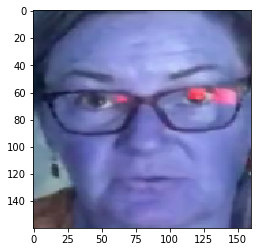

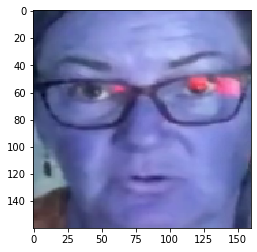

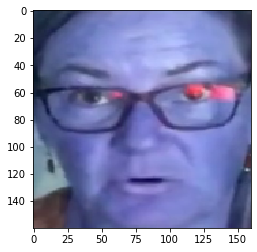

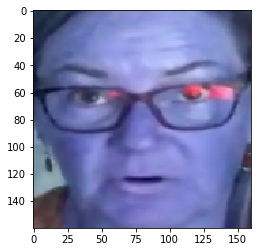

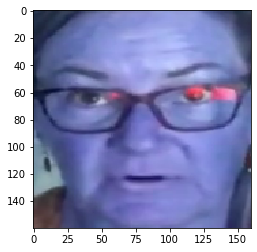

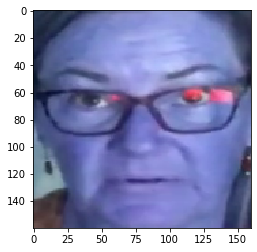

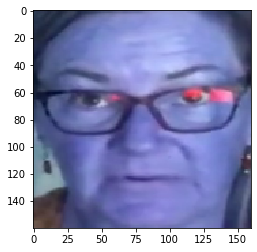

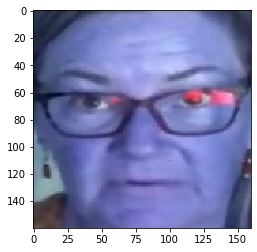

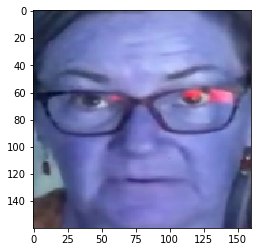

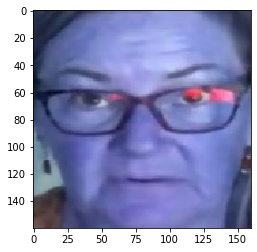

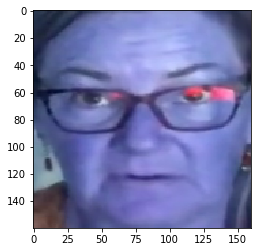

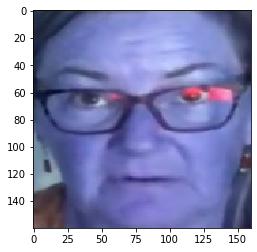

*

In [24]:
vid_num = 0
all_vid = len(test_videos_path)
filename = []
label = []
mtcnn = MTCNN()
# origin 영상 얼굴찾기
for vid_num, vid in enumerate(test_videos_path):
    frame = 0
    vid_name = vid.split('/')[-1]
    pred = 0
    detect_face_num = 0
    before_face_img_coord = []
    cap = cv2.VideoCapture(vid)
    while(cap.isOpened()):
        if frame == 15:
            break
        ret, img = cap.read()
        if ret == False:
            break

            
        if not before_face_img_coord:
            face = mtcnn.detect_faces(img)
            if not face: continue
            x1,y1,w,h = face[0]['box']
            x2 = min(x1+w, img.shape[1])
            y2 = min(y1+h, img.shape[0])
            x1 = max(x1, 0)
            y1 = max(y1, 0)
            crop_img = img[y1:y2, x1:x2]
            
            
            crop_img = cv2.resize(crop_img, (160, 160))
            
            
#             plt.imshow(crop_img)
#             plt.show()
            
            
            crop_img = (crop_img.flatten() / 255.0).reshape(-1, 160, 160, 3)
            pred += model.predict(crop_img)[0][1]
            
            
            before_face_img_coord = [y1,y2,x1,x2]
            detect_face_num += 1
            
        # 이전에 얼굴을 검출했으면 그주변에서 검색
        else:
            im = img[max(before_face_img_coord[0]-50,0) : min(before_face_img_coord[1]+50,img.shape[0]),
                        max(before_face_img_coord[2]-50,0) : min(before_face_img_coord[3]+50,img.shape[1])]
            face = mtcnn.detect_faces(im)
            if face:
                x11,y11,w,h = face[0]['box']
                x1 = max(max(before_face_img_coord[2]-50, 0) + x11, 0)
                x2 = min(x1 + w, img.shape[1])
                y1 = max(max(before_face_img_coord[0]-50, 0) + y11, 0)
                y2 = min(y1 + h, img.shape[0])
                crop_img = img[y1:y2, x1:x2]
                
                
                crop_img = cv2.resize(crop_img, (160, 160))
                
#                 plt.imshow(crop_img)
#                 plt.show()
                
                
                crop_img = (crop_img.flatten() / 255.0).reshape(-1, 160, 160, 3)
                pred += model.predict(crop_img)[0][1]
                
                
                before_face_img_coord = [y1,y2,x1,x2]
                detect_face_num += 1
                

        frame += 1

    if before_face_img_coord:
        acc = pred/detect_face_num
        #acc = pred/300
    else:
        acc = 0.5
        
    filename.append(vid_name)
    label.append(acc)
    
    print('*',end='')
    if (vid_num+1) % 50 == 49:
        print(vid_num,'/',all_vid)

In [ ]:
# vid_num = 0
# all_vid = len(test_videos_path)
# filename = []
# score = []
# # origin 영상 얼굴찾기
# for vid_num, vid in enumerate(test_videos_path):
#     frame = 0
#     vid_name = vid.split('/')[-1]
#     before_face_img_coord = []
#     cap = cv2.VideoCapture(path)
#     while(cap.isOpened()):
#         if frame == 300:
#             break
#         ret, img = cap.read()
#         if ret == False:
#             break
        
#         # 처음이면
#         if not before_face_img_coord:
#             face = mtcnn.detect_faces(img)
#             # 처음인데 얼굴이 없으면 0.5로
#             if not face:
#                 break
#             x1,y1,w,h = face['box']
#             x2 = min(x1+w, img.shape[1])
#             y2 = min(y1+h, img.shape[0])
#             x1 = max(x1, 0)
#             y1 = max(y1, 0)
#             crop_img = img[y1:y2, x1:x2]
#             crop_img = cv2.resize(crop_img, (299, 299))
#             np.append(face_images, crop_img)
#             before_face_img_coord = [y1,y2,x1,x2]
                
#         # 이전에 얼굴을 검출했으면 그주변에서 검색
#         else:
#             im = image[max(before_face_img_coord[0]-200,0) : min(before_face_img_coord[1]+200,img.shape[0]),
#                         max(before_face_img_coord[2]-200,0) : min(before_face_img_coord[3]+200,img.shape[1])]
#             face = mtcnn.detect_faces(im)
#             if face:
#                 x11,y11,w,h = face[0]['box']
#                 x1 = max(max(coord[2]-200, 0) + x11, 0)
#                 x2 = min(x1 + w, img.shape[1])
#                 y1 = max(max(coord[0]-200, 0) + y11, 0)
#                 y2 = min(y1 + h, img.shape[0])
#                 crop_img = img[y1:y2, x1:x2]
#                 crop_img = cv2.resize(crop_img, (299, 299))
#                 np.append(face_images, crop_img)
#                 before_face_img_coord=[y1,y2,x1,x2]
            
#             # 검색 안됐으면 그전 사진으로
#             else:
#                 crop_img = img[before_face_img_coord[0]:before_face_img_coord[1],
#                                before_face_img_coord[2]:before_face_img_coord[3]]
#                 np.append(face_images, crop_img)
#         frame += 1

#     print(face_images.shape) # must be (1, 300, 299, 299, 3)
#     if face_images:
#         pred = model.predict(face_images)
#     else:
#         pred = 0
#     filename.append(vid_name)
#     label.append(pred)
    
#     print('*',end='')
#     if (vid_num+1) % 50 == 49:
#         print(vid_num,'/',all_vid)

In [ ]:
my_submission = pd.DataFrame({'filename': filename, 'label': label})

In [ ]:
my_submission.loc[my_submission['label']==1,'label'] = 0.95
my_submission.loc[my_submission['label']==0,'label'] = 0.05
my_submission

In [ ]:
my_submission.to_csv('submission.csv', index=False)